### Forecasting Competition

In this competition we'll be forecasting the total water availability across four major reservoirs in Chennai.

Data is provided on water availability in each of the four major reservoirs for the period 2004-2018. The data is available on a daily basis and the unit is million cubic feet.

An additional data set is provided with daily rainfall (in mm) in each of the four regions for the period 2004-2018.

Objective: <br>
**Forecast the total water availability across the four reservoirs for every day in 2019**

Prepare a predictions.csv file with the following format:

Date, Total Water
2019-01-01, 100.0
2019-01-02, 102.0
2019-01-03, 107.0
...

We'll evaluate the forecast accuracy on the true held-out test set using the four metrics outlined in the textbook: RMSE, MAE.


Notes:
- My expectation is there is likely seasonality in the data and so I'm probably going to go with some sort of exponential smoothing model (probably some variant that takes into account seasonality)
- For fun I'm going to try FB Prophet as well to see if I can get a model that works well from there
- For now I'm going to skip any ARIMA based approaches, althought this might ultimately be a mistake

### Setup

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.plotting.register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error

from fbprophet import Prophet

In [2]:
data_reservoir = pd.read_csv('../competition/train_reservoir_levels.csv', index_col=0, parse_dates=True)
data_reservoir['TOTAL'] = data_reservoir.apply(sum, axis=1)

data_rainfall = pd.read_csv('../competition/train_rainfall.csv', index_col=0, parse_dates=True)
data_rainfall['TOTAL'] = data_rainfall.apply(sum, axis=1)

In [3]:
data_reservoir.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2004-01-01 to 2018-12-31
Data columns (total 5 columns):
POONDI             5479 non-null float64
CHOLAVARAM         5479 non-null float64
REDHILLS           5479 non-null float64
CHEMBARAMBAKKAM    5479 non-null float64
TOTAL              5479 non-null float64
dtypes: float64(5)
memory usage: 256.8 KB


In [4]:
data_reservoir.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM,TOTAL
count,5479.000000,5479.000000,5479.000000,5479.000000,5479.000000
mean,1160.626050,246.421823,1604.739816,1361.172322,4372.960011
std,1029.241954,276.277375,877.350937,943.820995,2940.201829
min,0.900000,0.000000,0.000000,0.000000,0.900000
25%,220.000000,25.000000,949.000000,535.500000,1948.600000
50%,822.000000,96.000000,1677.000000,1262.000000,3944.000000
75%,2039.000000,468.000000,2259.000000,2124.000000,6687.500000
max,3231.000000,896.000000,3300.000000,3396.000000,10568.000000


In [5]:
data_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2004-01-01 to 2018-12-31
Data columns (total 5 columns):
POONDI             5479 non-null float64
CHOLAVARAM         5479 non-null float64
REDHILLS           5479 non-null float64
CHEMBARAMBAKKAM    5479 non-null float64
TOTAL              5479 non-null float64
dtypes: float64(5)
memory usage: 256.8 KB


In [6]:
data_rainfall.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM,TOTAL
count,5479.000000,5479.000000,5479.000000,5479.000000,5479.000000
mean,3.460896,3.727542,3.871874,4.044178,15.104490
std,12.931613,14.278706,15.275190,16.520367,53.431874
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,3.000000
max,300.000000,293.000000,320.000000,475.000000,1277.400000


### Exploratory Data Analysis

#### Reservoir Levels

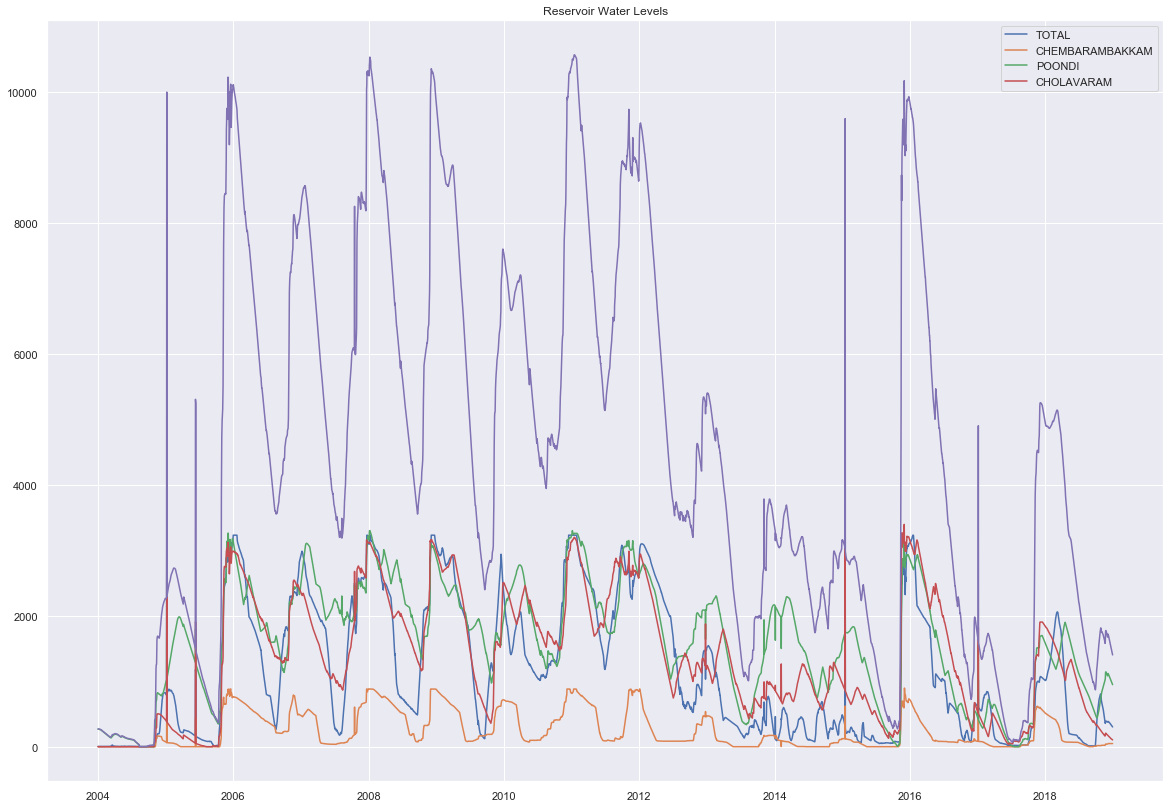

In [7]:
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111)
ax.set_title("Reservoir Water Levels")
ax.plot(data_reservoir)
ax.legend(['TOTAL', 'CHEMBARAMBAKKAM', 'POONDI', 'CHOLAVARAM'])
plt.show();

Let's zoom into one of the periods where we're seeing a huge spike 2014-2015.

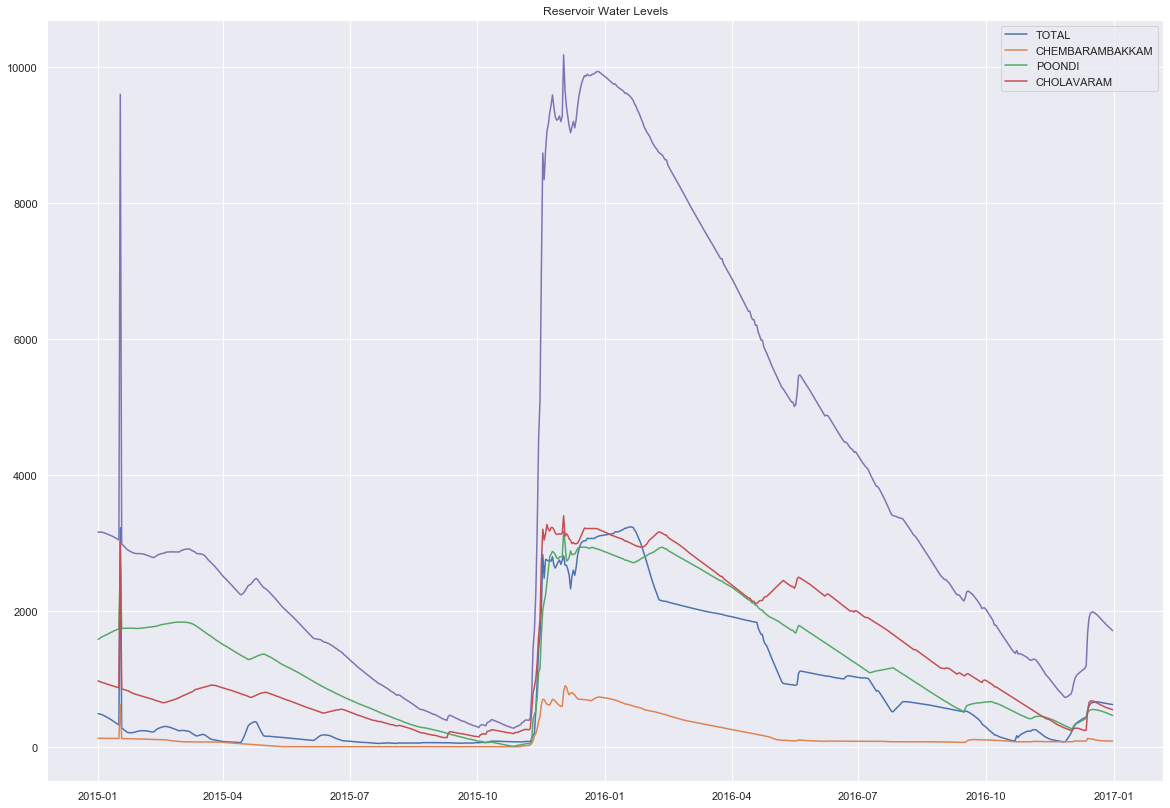

In [8]:
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111)
ax.set_title("Reservoir Water Levels")
ax.plot(data_reservoir.loc['2015':'2016'])
ax.legend(['TOTAL', 'CHEMBARAMBAKKAM', 'POONDI', 'CHOLAVARAM'])
plt.show();

Based on the time series plots it seems quite reasonable to work with the Total Reservoir Levels directly, don't see an advantage of working with the regional level data.

#### Rainfall Levels

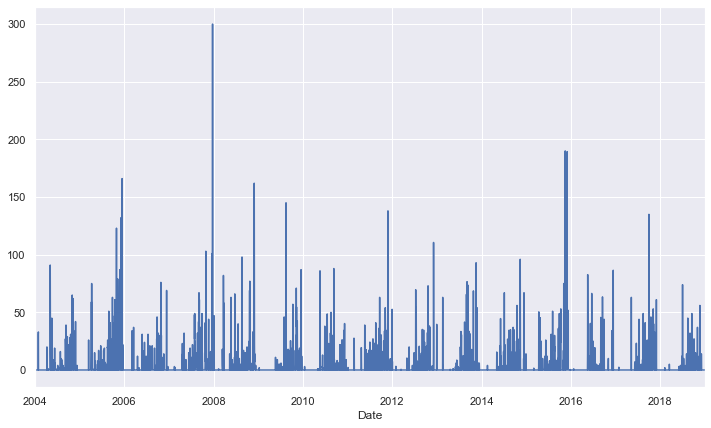

In [11]:
data_rainfall['POONDI'].plot(figsize=(12, 7));

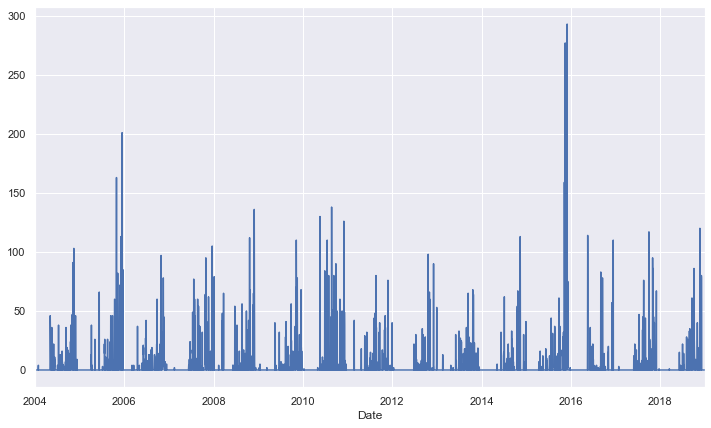

In [12]:
data_rainfall['CHOLAVARAM'].plot(figsize=(12, 7));

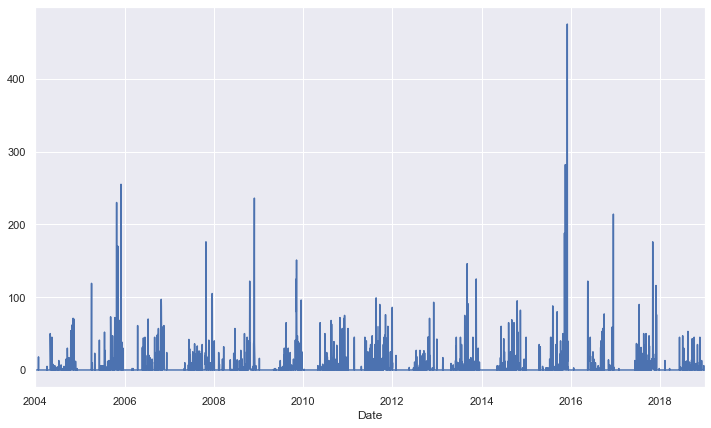

In [13]:
data_rainfall['CHEMBARAMBAKKAM'].plot(figsize=(12, 7));

Lots of seasonality in the data and once again I don't see any distinct advantage to looking at regional level information, will focus on the aggregate TOTAL daily rainfall.

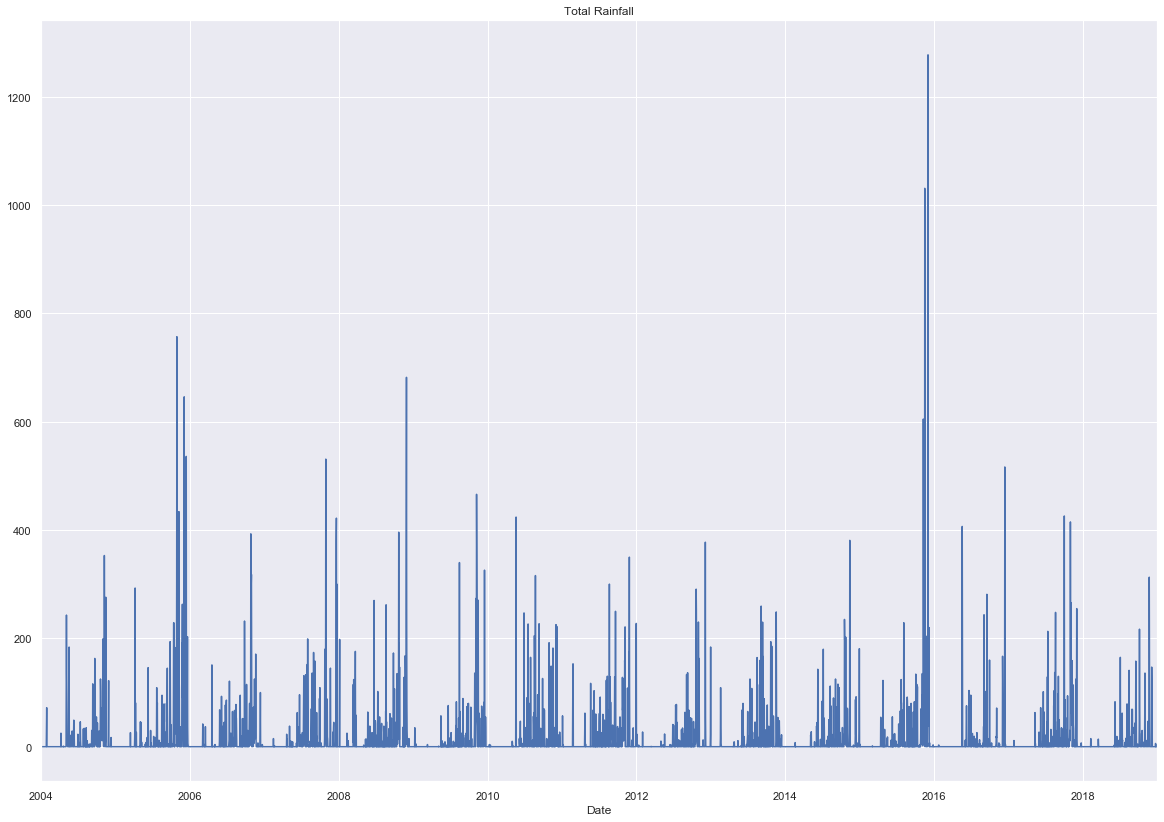

In [14]:
data_rainfall['TOTAL'].plot(figsize=(20, 14), title='Total Rainfall');

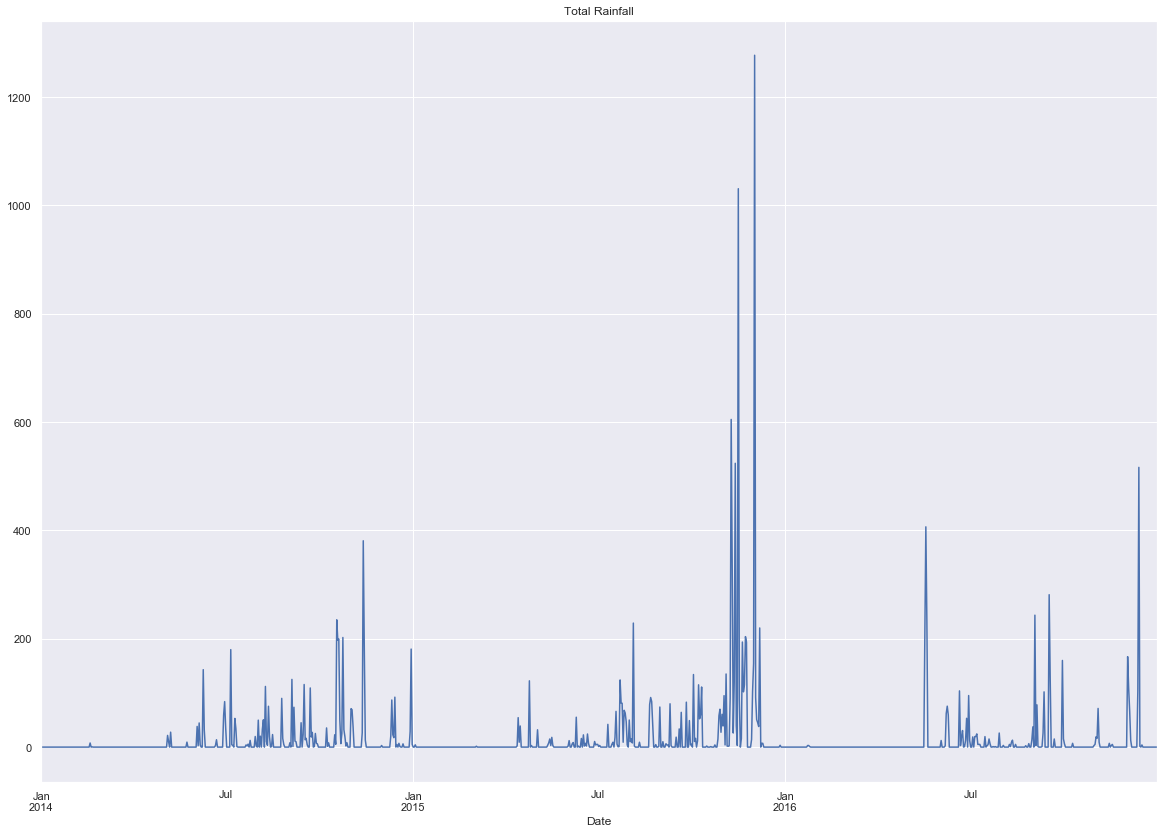

In [15]:
data_rainfall['TOTAL'].loc['2014':'2016'].plot(figsize=(20, 14), title='Total Rainfall');

Very interesting in that I'm not seeing that one day spike in the data in early 2015 that I saw in the reservoir levels. Could potentially be some anomalous values or suggestive that something else is driving the underlying trend.

Let's look at the first difference of both data series and their correlation with each other.

In [16]:
total_df = data_reservoir[['TOTAL']]
total_df.columns = ['Reservoir']
total_df = pd.merge(total_df, data_rainfall[['TOTAL']], how='outer', left_index=True, right_index=True)
total_df.columns = ['Reservoir', 'Rainfall']

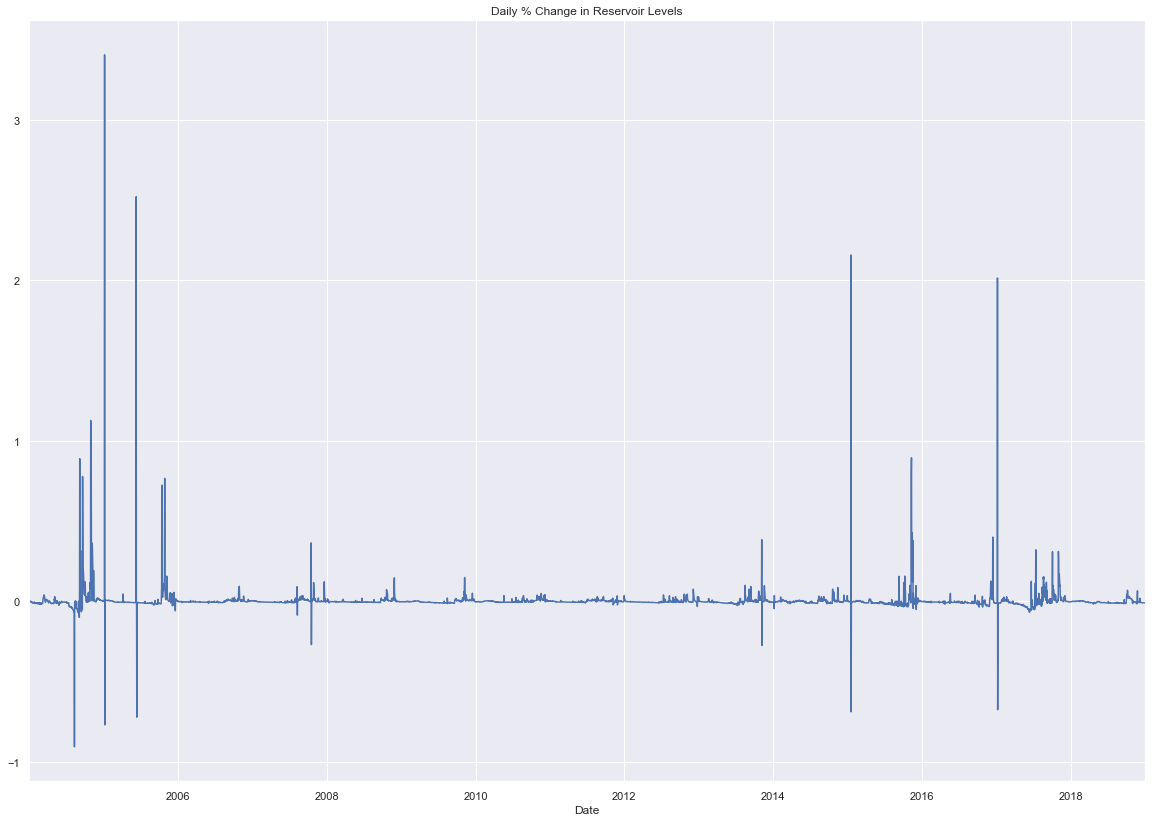

In [17]:
total_df['Reservoir'].pct_change().dropna().plot(figsize=(20, 14), title='Daily % Change in Reservoir Levels');

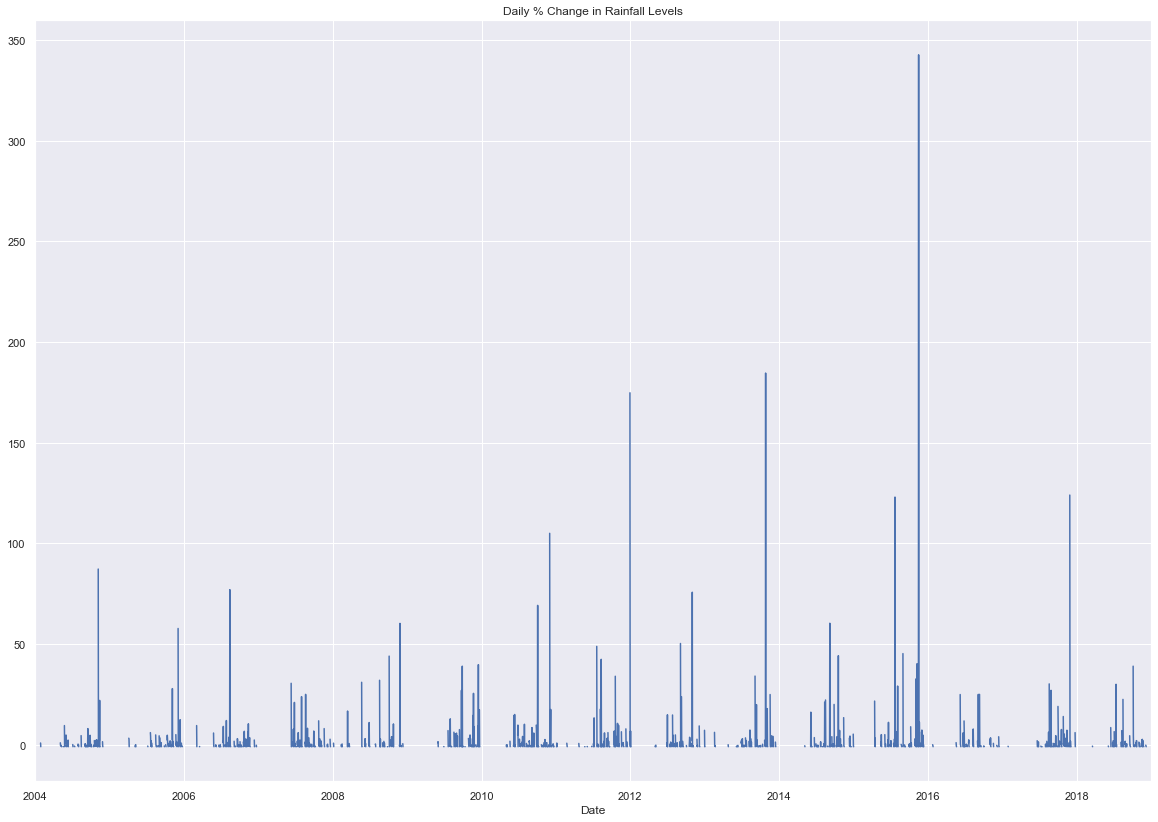

In [18]:
total_df['Rainfall'].pct_change().plot(figsize=(20, 14), title='Daily % Change in Rainfall Levels');

Don't seem stationary just by looking at the data, will run hypothesis test and look at autocorrelation.

In [19]:
result = adfuller(total_df['Reservoir'].pct_change().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.426598
p-value: 0.000000


In [20]:
result = kpss(total_df['Reservoir'].pct_change().dropna(), regression='c')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KPSS Statistic: 0.266462
p-value: 0.100000


/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


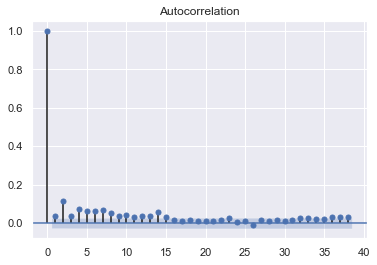

In [21]:
plot_acf(total_df['Reservoir'].pct_change().dropna()); 

Contrary to my intial thoughts Reservoir data looks to be stationary

In [22]:
result = adfuller(total_df['Rainfall'].pct_change().replace(np.inf, np.nan).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -41.019723
p-value: 0.000000


In [23]:
result = kpss(total_df['Rainfall'].pct_change().replace(np.inf, np.nan).dropna(), regression='c')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KPSS Statistic: 0.430530
p-value: 0.063996


/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


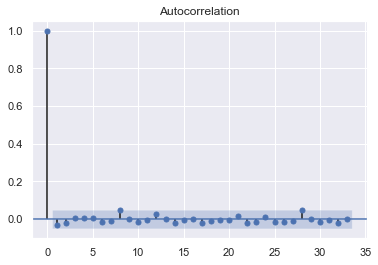

In [24]:
plot_acf(total_df['Rainfall'].pct_change().replace(np.inf, np.nan).dropna());

Both are stationary and I wouldn't have expected that at all given the data.

In [25]:
total_df.pct_change().replace(np.inf, np.nan).dropna().corr()

,Reservoir,Rainfall
Reservoir,1.000000,0.085398
Rainfall,0.085398,1.000000


In [26]:
total_df['Rainfall_Lag30'] = total_df['Rainfall'].shift(30)

In [27]:
total_df[['Reservoir', 'Rainfall_Lag30']].pct_change().corr()

,Reservoir,Rainfall_Lag30
Reservoir,1.000000,-0.010652
Rainfall_Lag30,-0.010652,1.000000


Looks like they are indeed uncorrelated even when lagging the rainfall data, as a result only going to use Resevoir data for my forecasting problem.

### Forecasting

Only going to use Resevoir total data for my forecasting, will setup a moving average model as my baseline, will split the data into train and test, select the best model on the train and then do my final model by running on the entire data set.

In [28]:
def check_residuals(residuals):
    fig = plt.figure(figsize=(20, 14))
    ax = fig.add_subplot(311)
    ax.set_title('Residuals')
    ax.plot(residuals)
    ax.grid(True)

    ax = fig.add_subplot(312)
    ax.set_title('Residuals ACF')
    plot_acf(residuals, lags=40, ax=ax)
    ax.grid(True)
    
    ax = fig.add_subplot(313)
    ax.set_title('Residuals Histogram')
    ax.hist(residuals)
    ax.grid(True)

In [29]:
df = data_reservoir[['TOTAL']]
df.columns = ['Resevoir']

train = df.loc['2004':'2017']
test = df.loc['2018']

#### Simple Moving Average

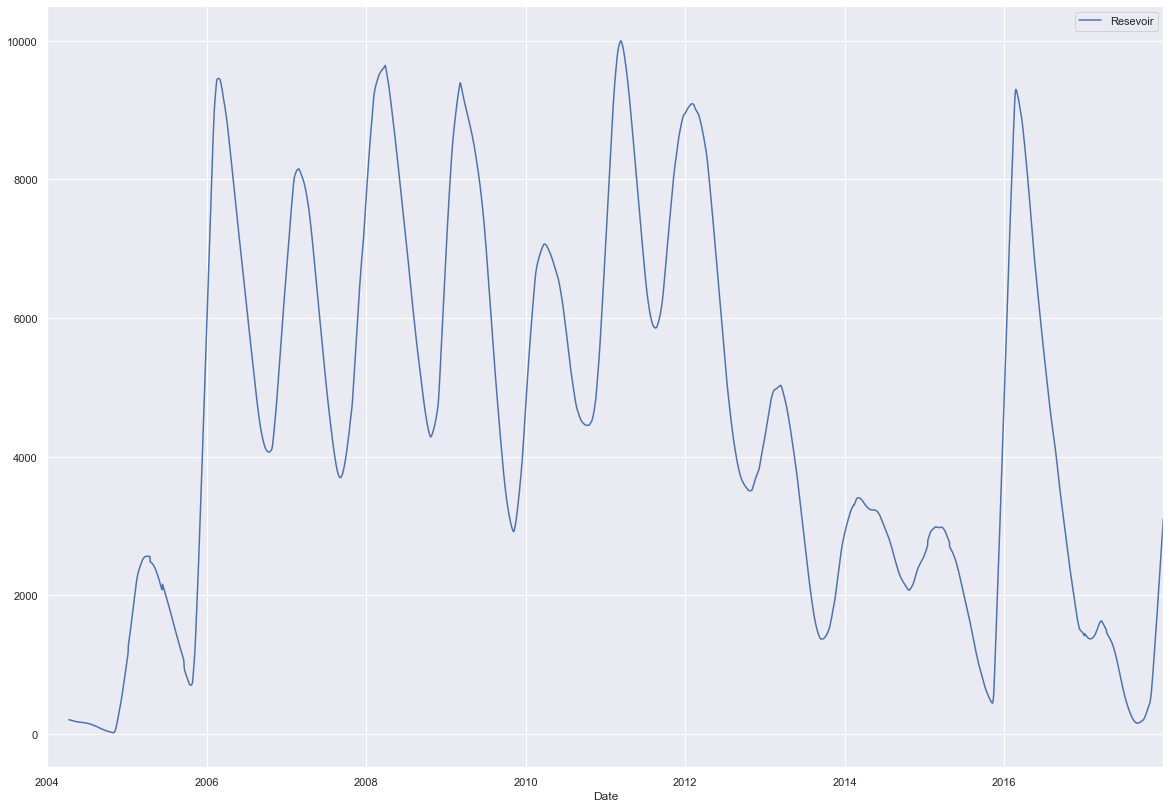

In [30]:
train.rolling(window=100).mean().plot(figsize=(20, 14));

In [31]:
# starting with a naive estimator that forecasts using the 365 day moving average for that day adjusting for time of year
# i.e. 2018-01-01 forecast is the moving average of the past 365 days for 2017-01-01

test['ma365'] = 0.0

In [32]:
ma365_predictions = {}

for date in train.loc['2017':'2018'].index:
    ma365_predictions[str(date.date())] = train.loc[:date].rolling(window=365).mean().values[-1][0]

In [33]:
test['ma365'] = ma365_predictions.values()

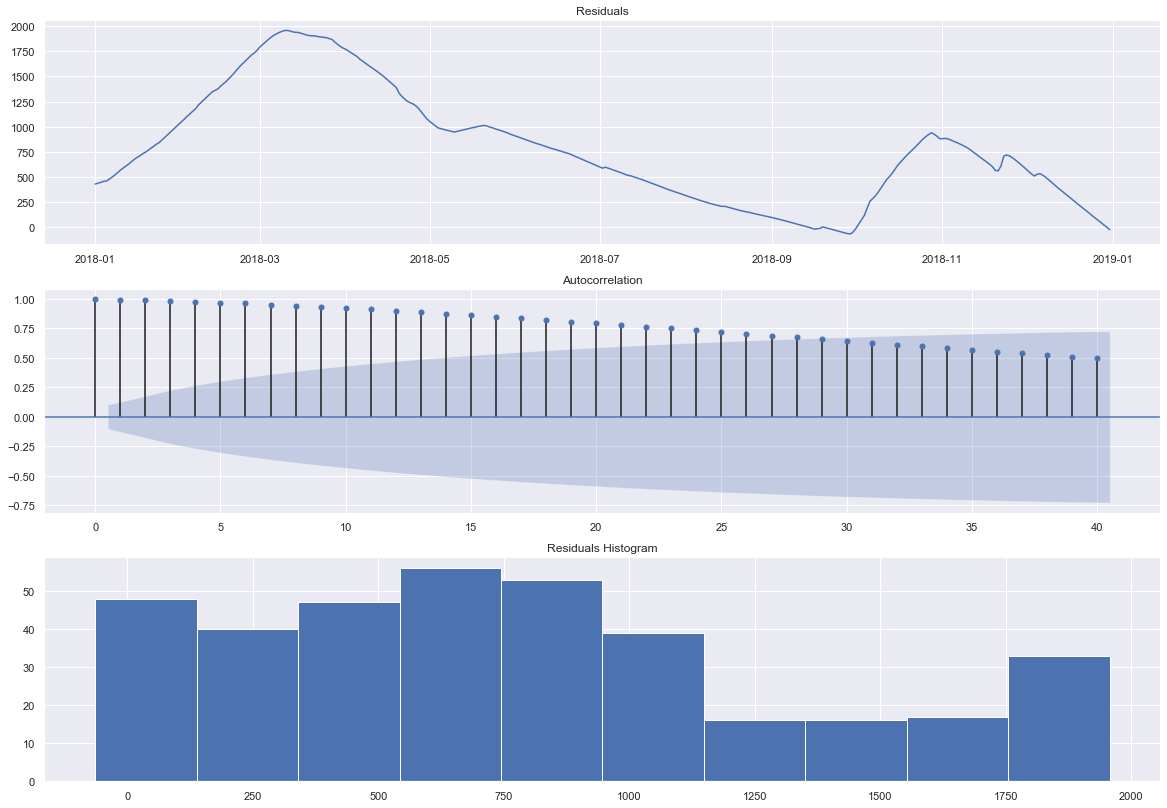

In [34]:
check_residuals(test['Resevoir'] - test['ma365'])

In [35]:
print(f"RMSE: {round(np.sqrt(mean_squared_error(test['Resevoir'], test['ma365'])), 3)}")
print(f"MAE: {round(mean_absolute_error(test['Resevoir'], test['ma365']),3)}")

RMSE: 960.416
MAE: 786.943


Alright so this is the method to beat, I'm going to use FB Prophet to try and improve on my forecasting method here.

#### Facebook Prophet

In [36]:
# adjust data to conform to FB Prophet's data layout expectation

train_prophet = train.reset_index()
train_prophet.columns = ['ds', 'y']

m = Prophet()
m.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [37]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5474,2018-12-27,4253.324982,2368.004520,6221.405531
5475,2018-12-28,4252.481282,2308.157150,6071.570883
5476,2018-12-29,4268.691809,2340.197498,6212.761358
5477,2018-12-30,4263.257541,2305.154690,6243.495746
5478,2018-12-31,4259.623661,2402.983483,6286.047176


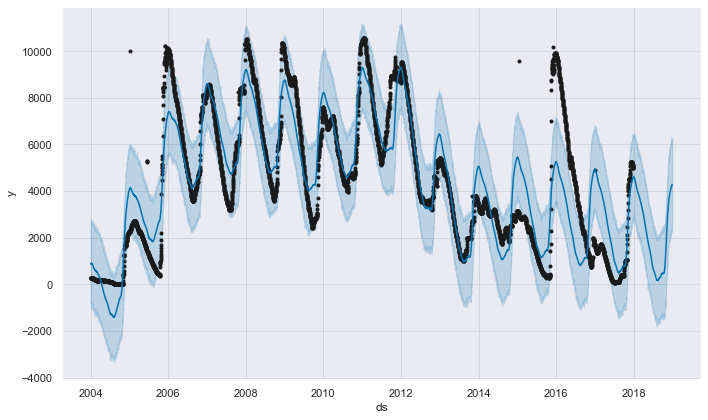

In [38]:
m.plot(forecast);

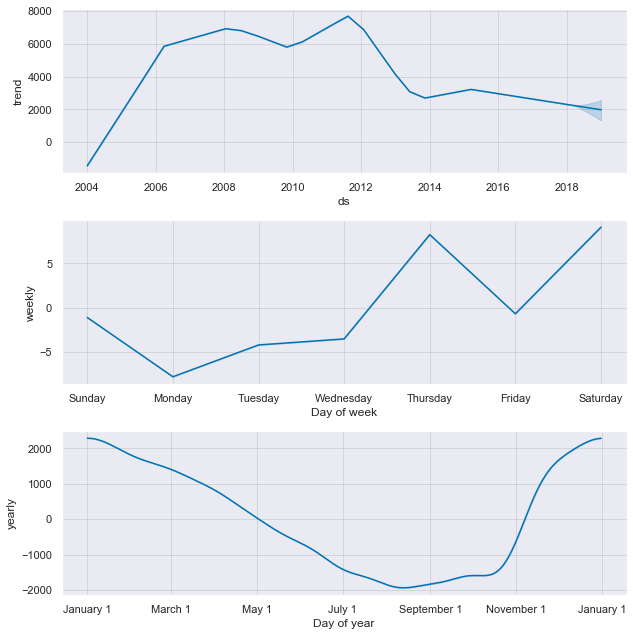

In [39]:
m.plot_components(forecast);

In [40]:
forecast[forecast['ds'] > '2017-12-31'][['ds', 'yhat']]

,ds,yhat
5114,2018-01-01,4588.583302
5115,2018-01-02,4591.390915
5116,2018-01-03,4589.605693
5117,2018-01-04,4597.250619
5118,2018-01-05,4582.577574
...,...,...
5474,2018-12-27,4253.324982
5475,2018-12-28,4252.481282
5476,2018-12-29,4268.691809
5477,2018-12-30,4263.257541


In [41]:
test['prophet_no_tuning'] = forecast[forecast['ds'] > '2017-12-31']['yhat'].values

In [42]:
print(f"RMSE: {round(np.sqrt(mean_squared_error(test['Resevoir'], test['prophet_no_tuning'])), 3)}")
print(f"MAE: {round(mean_absolute_error(test['Resevoir'], test['prophet_no_tuning']),3)}")

RMSE: 1349.582
MAE: 1237.264


With no tuning it did worse than a vanilla 365 day moving average model, let's try tuning it and selecting hyperparameters via cross-validation.

In [45]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    m = Prophet(**params).fit(train_prophet)  # Fit model with given params
    df_cv = cross_validation(m, horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

  0%|          | 0/16 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Making 21 forecasts with cutoffs between 2007-01-03 00:00:00 and 2016-12-31 00:00:00
  6%|▋         | 1/16 [01:19<19:46, 79.12s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 21 forecasts with cutoffs between 2007-01-03 00:00:00 and 2016-12-31 00:00:00
 12%|█▎        | 2/16 [03:08<20:36, 88.30s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 21 forecasts with cutoffs between

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  3458.574495
1                     0.001                     0.10  3444.269869
2                     0.001                     1.00  3469.324978
3                     0.001                    10.00  3467.123052
4                     0.010                     0.01  2761.587229
5                     0.010                     0.10  2765.182398
6                     0.010                     1.00  2779.502810
7                     0.010                    10.00  2761.150047
8                     0.100                     0.01  2940.786529
9                     0.100                     0.10  2833.210603
10                    0.100                     1.00  2838.606372
11                    0.100                    10.00  2833.334700
12                    0.500                     0.01  3063.994462
13                    0.500                     0.10  2935.941310
14        

In [54]:
tuning_results.min()

changepoint_prior_scale       0.001000
seasonality_prior_scale       0.010000
rmse                       2761.150047
dtype: float64

In [43]:
m = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)
m.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [44]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5474,2018-12-27,4994.723068,2015.491900,7865.684163
5475,2018-12-28,4981.225990,2142.072499,7851.449054
5476,2018-12-29,4981.656311,1887.583847,7880.944241
5477,2018-12-30,4963.424861,2116.886575,7981.778309
5478,2018-12-31,4947.038633,1972.214956,8025.241600


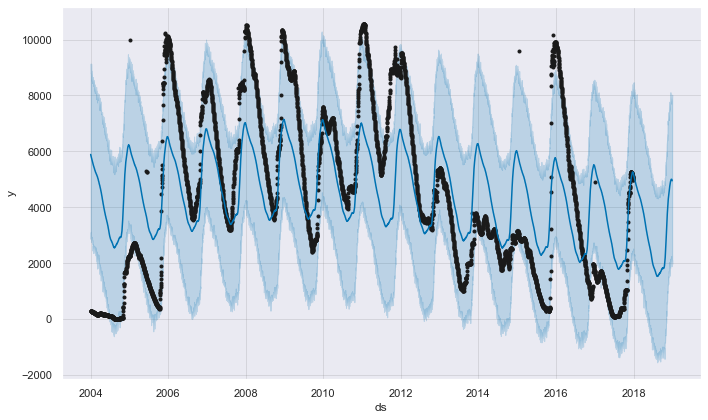

In [45]:
m.plot(forecast);

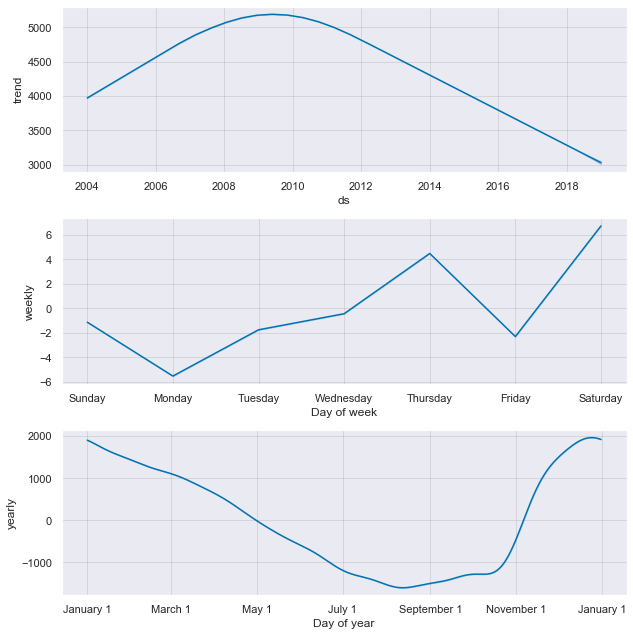

In [46]:
m.plot_components(forecast);

In [47]:
test['prophet_tuned'] = forecast[forecast['ds'] > '2017-12-31']['yhat'].values

In [48]:
print(f"RMSE: {np.sqrt(round(mean_squared_error(test['Resevoir'], test['prophet_tuned']), 3))}")
print(f"MAE: {round(mean_absolute_error(test['Resevoir'], test['prophet_tuned']),3)}")

RMSE: 1208.8594479921974
MAE: 772.944


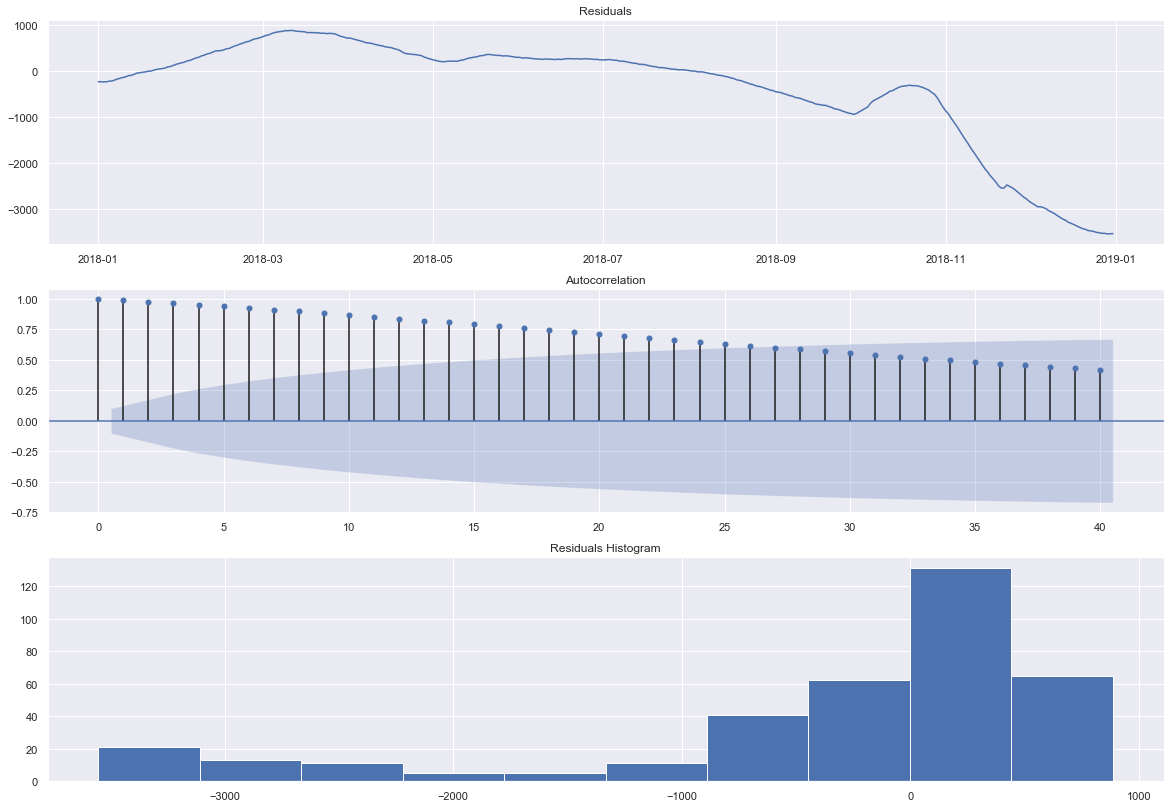

In [49]:
check_residuals(test['Resevoir'] - test['prophet_tuned'])

Still not doing a great job especially in comparison to the basic moving average model, perhaps I'll now try the exponential smoothing methods

#### Exponential Smoothing

/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/miniconda3/envs/realpython/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


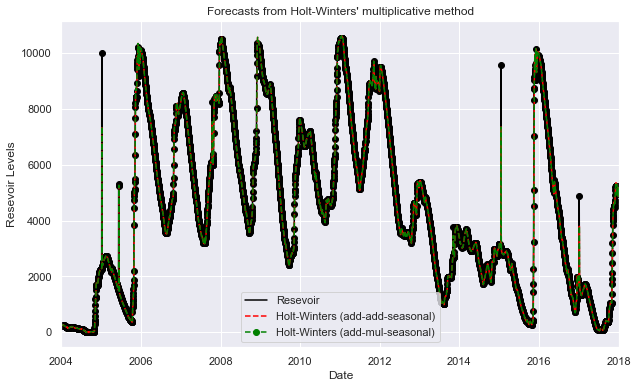

,Additive,Multiplicative,Additive Dam,Multiplicative Dam
$\alpha$,6.307235e-01,6.299533e-01,6.307235e-01,6.299533e-01
$\beta$,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
$l_0$,4.480087e+03,4.480086e+03,4.480087e+03,4.480086e+03
SSE,2.674618e+08,2.674741e+08,2.674618e+08,2.674741e+08


In [85]:
fit1 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit()
fit2 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul').fit()
fit3 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit()
fit4 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul').fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$l_0$","SSE"])
params = ['smoothing_level', 'smoothing_seasonal', 'initial_level']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplicative Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = train.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Resevoir Levels")
ax.set_xlabel("Date")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(8).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()

results

In [89]:
fit1.forecast(365)

2018-01-01    5006.268580
2018-01-02    5017.983232
2018-01-03    5024.929431
2018-01-04    5040.906480
2018-01-05    5059.110711
                 ...     
2018-12-27    9762.060377
2018-12-28    9773.775029
2018-12-29    9780.721227
2018-12-30    9796.698276
2018-12-31    9814.902508
Freq: D, Length: 365, dtype: float64

These are all considerably worse than the simple moving average, going to go back and see if I can tweak it to behave better.

#### Output
Going to now run my 365 days moving average model on the entire data to construct predictions for the competition test set.

In [109]:
predictions = {}

for date in df.loc['2018'].index:
    predictions[str(date.date())] = df.loc[:date].rolling(window=365).mean().values[-1][0]

In [114]:
output = pd.DataFrame(predictions.values(), columns=['Total Water'], index=pd.date_range('2019-01-01', '2019-12-31'))

In [116]:
output.to_csv('nishant_predictions.csv')